In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import json
import numpy as np

<h1>Load and read dataset</h1>

In [2]:
def read_dataset(path):
    return json.load(open(path)) 

train = read_dataset('../IME672/train.json')
test = read_dataset('../IME672/test.json')


<h1>Converting lists of ingredients to strings</h1>

In [3]:
def generate_text(data):
    text_data = [" ".join(doc['ingredients']).lower() for doc in data]
    return text_data 

In [4]:
train_text = generate_text(train)
test_text = generate_text(test)
target = [doc['cuisine'] for doc in train]
cuisines = set(target)


In [5]:
tfidf = TfidfVectorizer(binary=True)
def tfidf_features(txt, flag):
    if flag == "train":
        x = tfidf.fit_transform(txt)
    else:
        x = tfidf.transform(txt)
    x = x.astype('float16')
    return x 
X = tfidf_features(train_text, flag="train")
X_test = tfidf_features(test_text, flag="test")


<h1>Converting the list of strings to the matrix of vectors</h1>
(to be fed our nn)

In [6]:
lb = LabelEncoder()
y = lb.fit_transform(target)
y_NN = keras.utils.to_categorical(y)


<h1>Build a model</h1>
<p>You can monkey with value of dropout to see how looks underfit/overfit (later). Also you can add other regularizers such as l1, l2.</p>
<p>He initializer works better with relu.</p>

In [7]:
model = keras.Sequential()
model.add(keras.layers.Dense(1000, kernel_initializer=keras.initializers.he_normal(seed=1), activation='relu', input_dim=3010))
model.add(keras.layers.Dropout(0.81))
model.add(keras.layers.Dense(1000, kernel_initializer=keras.initializers.he_normal(seed=2), activation='relu'))
model.add(keras.layers.Dropout(0.81))
model.add(keras.layers.Dense(20, kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=4), activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

W0706 17:24:47.357892 140523999270720 nn_ops.py:4224] Large dropout rate: 0.81 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0706 17:24:47.409835 140523999270720 nn_ops.py:4224] Large dropout rate: 0.81 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0706 17:24:47.433847 140523999270720 deprecation.py:506] From /home/akash/anaconda3/envs/my_env/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:143: calling RandomNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<h1>Training the Neural Network model</h1>

<h1>Plotting learning curves</h1>
Learning curves show us overting/underfiting

In [8]:
from sklearn.model_selection import train_test_split

X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X, y_NN , random_state = 0)

history = model.fit(X_train_NN, y_train_NN, epochs=20, batch_size=512, validation_split=0.1)

# model.save_weights("model.h5")
# print("Saved model to disk")


Train on 26847 samples, validate on 2983 samples
Epoch 1/20
26847/26847 [==============================] - 7s 276us/sample - loss: 2.3041 - acc: 0.3366 - val_loss: 1.5860 - val_acc: 0.5585
Epoch 2/20
26847/26847 [==============================] - 6s 213us/sample - loss: 1.4375 - acc: 0.5889 - val_loss: 1.0475 - val_acc: 0.6856
Epoch 3/20
26847/26847 [==============================] - 6s 221us/sample - loss: 1.1126 - acc: 0.6693 - val_loss: 0.8971 - val_acc: 0.7301
Epoch 4/20
26847/26847 [==============================] - 6s 215us/sample - loss: 0.9700 - acc: 0.7093 - val_loss: 0.8165 - val_acc: 0.7560
Epoch 5/20
26847/26847 [==============================] - 6s 226us/sample - loss: 0.8695 - acc: 0.7393 - val_loss: 0.7694 - val_acc: 0.7754
Epoch 6/20
26847/26847 [==============================] - 6s 214us/sample - loss: 0.8004 - acc: 0.7605 - val_loss: 0.7434 - val_acc: 0.7838
Epoch 7/20
26847/26847 [==============================] - 6s 230us/sample - loss: 0.7423 - acc: 0.7784 - val_lo

In [9]:
score=model.evaluate(X_test_NN,y_test_NN)

9944/9944 [==============================] - 2s 158us/sample - loss: 0.7158 - acc: 0.8031


In [10]:
y_predict_NN=model.predict(X_test_NN)
predictions_encoded = lb.inverse_transform([np.argmax(pred) for pred in y_predict_NN])
y_predict_NN = lb.fit_transform(predictions_encoded)
y_test_NN_encoded=lb.inverse_transform([np.argmax(pred) for pred in y_test_NN])
y_test_NN = lb.fit_transform(y_test_NN_encoded)



NameError: name 'summary' is not defined

In [11]:
summary = np.zeros((20, 20), dtype=np.int32)

for y_test_i, y_predict_i in zip(y_test_NN, y_predict_NN):
    summary[y_test_i, y_predict_i] += 1

summary_df = pd.DataFrame(summary, 
                          columns=cuisines, 
                          index=cuisines)

summary_df

,mexican,cajun_creole,jamaican,spanish,vietnamese,russian,japanese,brazilian,southern_us,italian,indian,thai,korean,chinese,irish,filipino,greek,british,french,moroccan
mexican,76,0,1,1,2,3,0,2,1,5,0,0,0,13,0,0,6,7,3,0
cajun_creole,0,99,2,0,1,28,1,4,12,11,2,0,0,2,1,1,32,0,2,0
jamaican,0,4,264,1,0,13,1,1,1,13,0,0,0,6,0,0,54,4,0,0
spanish,0,1,1,599,4,3,0,1,0,8,0,11,25,3,0,1,9,1,12,17
vietnamese,1,1,1,21,106,3,0,3,1,5,0,5,1,10,0,1,7,0,8,7
russian,0,19,4,3,2,439,3,0,10,106,2,2,0,6,3,12,34,12,0,1
japanese,0,1,0,0,1,6,220,2,1,46,0,0,0,6,7,1,3,8,0,0
brazilian,1,1,0,2,3,2,3,724,0,4,0,1,0,12,10,2,3,4,10,1
southern_us,0,17,1,0,1,15,0,2,82,10,1,0,1,1,0,2,26,0,0,0
italian,1,2,8,1,0,76,34,5,5,1722,0,1,0,10,4,3,35,23,2,0


<h1>Plotting learning curves</h1>
Learning curves show us overting/underfiting

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


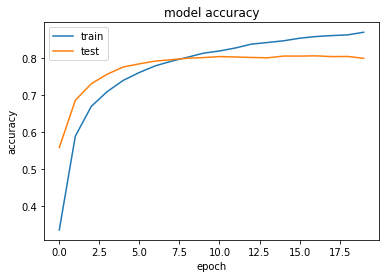

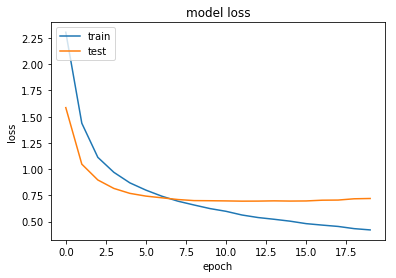

In [12]:
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [13]:
predictions_encoded = model.predict(X_test)
predictions_encoded.shape

(9944, 20)

<h1>Converting predicted vectors to names of cuisines</h1>

In [14]:
predictions = lb.inverse_transform([np.argmax(pred) for pred in predictions_encoded])


<h1>Submission</h1>

In [15]:
test_id = [doc['id'] for doc in test]
sub = pd.DataFrame({'id': test_id, 'cuisine': predictions}, columns=['id', 'cuisine'])
sub.to_csv('output.csv', index=False)

In [16]:
# Model Training 
print ("Train the model ... ")
classifier = SVC(C=100, # penalty parameter
	 			 kernel='rbf', # kernel type, rbf working fine here
	 			 degree=3, # default value
	 			 gamma=1, # kernel coefficient
	 			 coef0=1, # change to 1 from default value of 0.0
	 			 shrinking=True, # using shrinking heuristics
	 			 tol=0.001, # stopping criterion tolerance 
	      		 probability=False, # no need to enable probability estimates
	      		 cache_size=200, # 200 MB cache size
	      		 class_weight=None, # all classes are treated equally 
	      		 verbose=False, # print the logs 
	      		 max_iter=-1, # no limit, let it run
          		 decision_function_shape=None, # will use one vs rest explicitly 
          		 random_state=None)
model_SVM = OneVsRestClassifier(classifier, n_jobs=1)

Train the model ... 


In [17]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X, y , random_state = 0)
model_SVM.fit(X_train_SVM, y_train_SVM)

OneVsRestClassifier(estimator=SVC(C=100, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [18]:
score=model_SVM.score(X_test_SVM,y_test_SVM)
print(score)


0.8199919549477072


In [19]:
y_predict_SVM = model_SVM.predict(X_test_SVM)
y_predict_SVM=lb.inverse_transform(y_predict_SVM)
y_predict_SVM = lb.fit_transform(y_predict_SVM)

summary = np.zeros((20, 20), dtype=np.int32)
for y_test_i, y_predict_i in zip(y_test_SVM, y_predict_SVM):
    summary[y_test_i, y_predict_i] += 1

summary_df = pd.DataFrame(summary, 
                          columns=cuisines, 
                          index=cuisines)

summary_df

,mexican,cajun_creole,jamaican,spanish,vietnamese,russian,japanese,brazilian,southern_us,italian,indian,thai,korean,chinese,irish,filipino,greek,british,french,moroccan
mexican,73,3,2,1,2,2,0,2,0,8,0,0,0,11,1,0,4,7,4,0
cajun_creole,0,110,1,1,0,20,1,6,12,13,2,1,0,3,0,3,23,1,1,0
jamaican,0,3,272,0,1,12,0,0,1,10,0,0,0,7,0,0,53,3,0,0
spanish,0,3,1,614,1,5,0,1,0,5,0,13,17,2,1,0,5,1,13,14
vietnamese,1,1,1,13,121,2,0,3,2,7,0,1,1,8,0,1,7,0,7,5
russian,0,15,3,2,2,454,3,4,6,103,1,3,1,11,1,8,35,5,0,1
japanese,0,0,0,0,0,11,221,5,0,44,0,0,0,5,6,1,5,4,0,0
brazilian,0,1,0,0,1,2,4,726,0,5,0,6,1,13,7,2,5,2,7,1
southern_us,0,15,0,0,0,12,2,0,97,11,1,0,1,2,0,0,16,2,0,0
italian,2,3,3,3,0,65,33,3,2,1752,0,2,0,12,5,5,34,7,1,0


In [ ]:
# Predictions 
print ("Predict on test data ... ")
# print(X_test)
y_test = model.predict(X_test)
print(y_test)
# print(y_test.shape
y_pred = lb.inverse_transform(y_test)


In [ ]:
print ("Generate Submission File ... ")
test_id = [doc['id'] for doc in test]
sub = pd.DataFrame({'id': test_id, 'cuisine': y_pred}, columns=['id', 'cuisine'])
sub.to_csv('svm_output.csv', index=False)